### 패키지 설정 

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


### 데이터 구성하기

CIFAR-100은 karas 안에 dataset에 있어 간편하게 가져올 수 있음

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

#### 데이터 pixel 정수값 범위 확인하기

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


CIFAR-100 또한 fashion_mnist처럼 0~255 값으로 구성되어 있다는 것을 볼 수 있음

#### pixel 정수값 정규화하기

사용할 데이터를 정규화 하지 않고 사용할 경우 최적값을 찾을 때 수렴하는 과정이 복잡하기 때문에 정규화 과정을 거치는 것이 좋다.

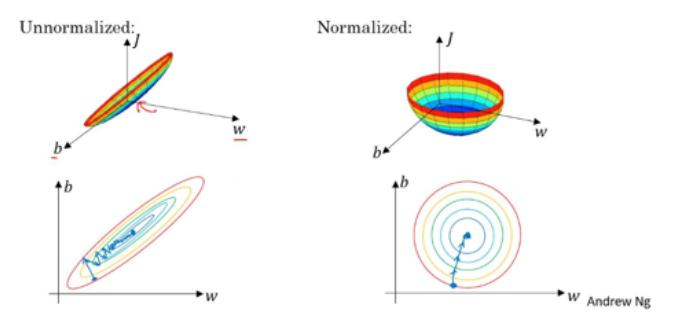

In [4]:
image_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/image/data_no.png'
Image(image_dir)

#### CIFAR-100 data 정규화하기

각 픽셀을 -1,1로 정규화함, 중간값을 0으로 맞추기 위해 127.5뺀 후 127.5로 나눔

In [5]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())
#max pixel: 1.0
#min pixel: -1.0
train_x.shape

max pixel: 1.0
min pixel: -1.0


(50000, 32, 32, 3)

train 데이터는 5만장으로 구성되어 있으며 이미지 사이즈는 32x32로 되어 있음
<br/>
CIFAR-100은 컬러로 구성되어 있어 chnnel은 3개로 구성되어 있는 것을 확인할 수 있음

#### 이미지 Sample 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


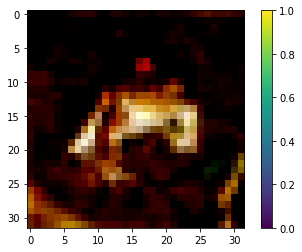

In [6]:
plt.imshow(train_x[0].reshape(32, 32,3))
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

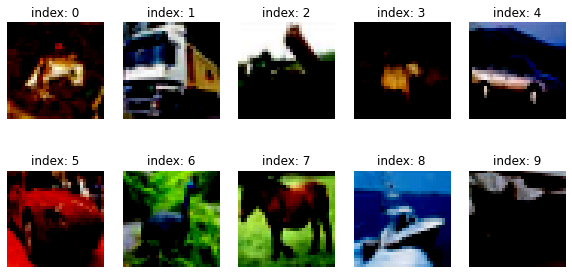

In [7]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(32, 32,3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

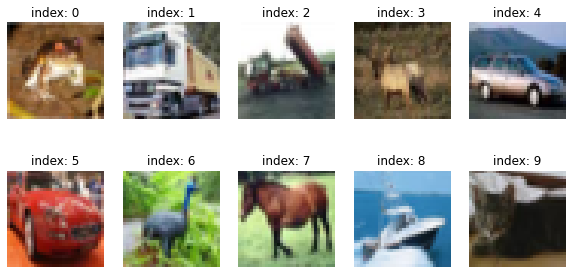

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    out = (train_x[i].reshape(32, 32,3))*127.5+127.5
    plt.imshow(np.uint8(out))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

정규화로 인해 0~1값으로 변경된 값으로 이미지 그리는 부분 오류 발생

오류: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

올바른 이미지인지 확인하기 위해 정규화 부분 빼고 확인하는 코드로 변경
<br/>
out = (train_x[i].reshape(32, 32,3))*127.5+127.5
<br/>
plt.imshow(np.uint8(out))

### 학습에 필요한 변수 지정

In [9]:
BUFFER_SIZE = 50000
BATCH_SIZE = 50

BUFFER_SIZE: 전체 데이터를 섞기 위해 지정한 것 <br/>
BATCH_SIZE: 모델이 한번에 학습할 데이터 양 지정

### mini batch 학습하기

많은 양을 한번에 학습하면 비효율적이기 때문에 적절한 사이즈로 잘라 학습 진행

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

from_tensor_slices() 사용하여 list,numpy 또는 tensorflow tensor 자료형으로 데이터 셋을 만들어 준다.
<br/>
train_x 넘파일 배열형 자료 섞고 batch size에 따라 나눔

### GAN 적용하기

GAN는 생성자와 판별자로 구성된 2가지 네트워크가 존재함

생성자(Generator): 의미 없는 랜덤 노이즈로부터 신경망에서 연산을 통해 이미지 형상의 벡터를 생성
<br/>
판별자(Discriminator): 진짜 이미지와 생성자가 만든 이미지를 입력받아 real인지 fake인지 판단 정도를 실수값으로 출력

### GAN 생성자 구현하기

DCGAN(Deep Convolutional GAN)을 사용하여 생성자 모델을 구현함

#### default 생성자 코드

In [11]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())# 신경망의 가중치가 폭발하지 않도록 가중치값 정규화
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    #activation='tanh': 활성화함수로 tanh 사용이유는 -1~1 이내의 값으로 픽셀값을 정규화 시키기 위해

    return model

#### 주로 사용된 코드 설명

#### Conv2DTranspose layer

Conv2DTranspose 레이어는 conv2D와 달리 이미지 사이즈를 넓혀주는 레이어


인자값으로는 (이미지 depth, kernel_sizem strides, padding, use_bais)로 되어 있음

이미지 depth는 최종 출력 이미지의 depth를 지정하는 것

kernel_size는 이미지 넓힐 때 사용되는 kernel 크기 지정
<br/>
stides는 kernel이 얼만큼 이동하는지를 지정

padding은 edge 사용하기 위해 사용됨

padding='valid', 'same'로 되어 있음
<br/>
'same'은 출력 이미지 사이즈와 입력 이미지 사이즈 동일하게 하는 것

conv2dTranspose output 계산 공식 : (i-1)*s+k-2p 계산 식에 의해 계산한 결과 padding szie는 2x2 결과가 나옴 <i: input, s: stride, k: kernel, p: padding>

padding='same'로 주어지는 경우에는 output size = input * stride 가 됨

#### 생성자 모델 구성

In [12]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

### 랜덤 노이즈 벡터 생성

In [13]:
noise = tf.random.normal([1, 100])

 tf.random.normal 사용하여 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터 구성

In [14]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

학습 중이기 때문에 training=false로 설정함
<br/>
[1,32,32,3]: 1= batch_size, 32,32,3 사이즈 이미지 생성됨

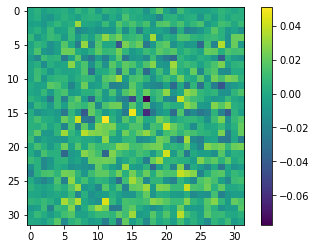

In [15]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

matplotlib은 2차원 이미지만 볼 수 있기 때문에 0,3번째 축의 인덱스를 0으로 설정 후 이미지 보여줌

### 판별자 구현하기

판별자는 가짜 이미지와 진짜 이미지를 입력 받으면 각 이미지 별로 진짜라고 판단하는 정도 값을 출력함

#### default 판별자

In [16]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

conv2DTranspose 층을 사용하여 이미지를 키워나갔기 때문에 판별자에서는 반대로 conv2d층을 활용하여 이미지 크기를 줄여나감

#### 판별자 model 구성 확인

In [17]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

마지막 Flatten층을 사용하여 3차원 이미지를 1차원 형태로 변환함
<br/>
생성자의 Reshape 층에 1차원 벡터를 3차원으로 변환했던것과 반대 역할을 함
<br/>
마지막 Dense Layer을 거쳐 단 하나의 값을 출력하는 형태로 함

In [18]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00270915]], dtype=float32)>

### 손실함수

GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용함
<br/>
점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 사용함

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

from_logits=True로 설정해야 BinaryCrossentropy에 입력된 값을 함수 내부에서 sigmoid함수를 사용해 0~1사이 값으로 정규화한 후 알맞게 계산할 수 있음
<br/>
 

#### 생성자 손실함수

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

생성자는 fake_output이 1에 가까워지기 바라기 때문에 tf.ones_like와 교차 엔트로피값을 계산함
<br/>
cross_entropy(tf.ones_like(fake_output), fake_output)값은 fake_output(real_image를 의미하는)이 1에 가까울수록 작은 값을 가짐

#### 판별자 손실함수

In [21]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

discriminator_loss는 real_output값이 1에 가까워지기를 fake_output에 가까워지기 바람, 두 가지 loss 값을 모두 계산해야함

판별자는 각 이미지 별로 진짜라고 판단되는 정도를 결과로 출력하는 것
<br/>
판별자 loss를 계산하기 위해서는 real_image와 fake_image의 결과 loss를 다 더한 값이 최종 판별자 loss가 됨

### 최적화 함수 적용하기

판별자가 real인지 fake인지 정확하게 판단하는 것이 중요하기 때문에 accuracy는 GAN 학습에 매우 중요한 것

accuracy이 1에 가깝게 나오는 경우는 생성자가 만들어내는 fake_image가 쉽게 구분되는 것을 뜻함
<br/>
real accuracy와 fake accuracy이 초반에는 1.0에 가깝게 나오다가 점차 낮아져 0.5에 가까워지는 것이 가장 이상적인 구조

In [22]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

tensorflow 함수들은 역할을 순차적으로 정리함. 

### 최적화 함수 적용하기

Adam최적화 기법을 활용함, learning_rate는 0.0001로 설정
<br/>
학습을 올리기 위해서는 여러 값을 바꾸어가며 학습을 진행

생성자와 구분자는 따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어 줘야 함

생성자가 생성한 Sample을 확인하여 학습이 어떻게 진행되고 있는지 확인할 수 있음

#### default 최적화 함수

In [23]:
# generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.7)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.7)

learning_rate: 미분을 통해 기울기를 구하는 가중치 값을 구할 때 학습하는 보폭을 결정

default 값
<br/>
beta_1= 0.9, bera_2: 0.999, learning_rate = 1e-3 or 5e-4

#### 같은 noise 생성을 위해 고정 seed 지정

In [25]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

Sample은 한번에 16장을 생성하도록 설정함
<br/>
매번 같은 noise로 생성해야 진전 과정을 확인할 수 있기 때문에 고정 seed를 만듦
<br/>
100차원의 nosie가 총 16개의 (16,100) shape을 가지는 벡터를 만듦

### 훈련과정 구현하기

tensorflow 2.0 이후부터 @tf.function이라는 데코레이터를 붙여주면 직접 session을 열어서 학습, 학습 완료 후 다시 닫는 번거러움을 안해도 됨

또한 계산 후 결과 타입을 동일하게 지정해줄 수 있음

In [26]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [27]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    #print(predictions.shape)
    # 16,32,32,3 이미지 있음
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]): # 총 16가지 이미지를 그림
        plt.subplot(4, 4, i+1)
        out = (predictions[i])*127.5+127.5
        plt.imshow(np.uint8(out))
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples_default_loss_change_epoch300/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [28]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history_defult_loss_change_epoch300/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

학습 과정을 확인하기 위해서는 시각화해야함, loss와 accuracy그래프 확인

In [29]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

장기적으로 모델을 저장하기 위한 checkoutpoiint를 만들어줌
<br/>
tf.train.Checkpoint을 활용하면 매번 모델을 직접 저장해 주지 않아도 버전 관리 할 수 있음

생성자와 판별자가 학습한 모델 가중치를 저장하기 위해 checkpoint에 optimizer와 생성자, 판별자 모두 넣음

### 모델 학습하기

In [30]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

#### 모델 간격 및 epoch 설정

In [31]:
save_every = 5
EPOCHS =50

모델 저장하는 간격인 save_every와 전체 학습 epoch를 결정하는 파라미터 설정

EPOCHS 값은 모델 수정 및 loss 수정할 때마다 100,300,500으로 설정하여 각 단계별로 학습이 개선되고 있는지 확인함

#### GPU 환경 확인하기

In [32]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### 학습하기

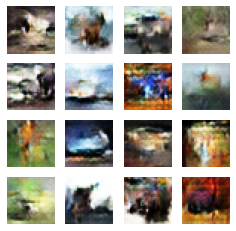

Time for training : 1357 sec


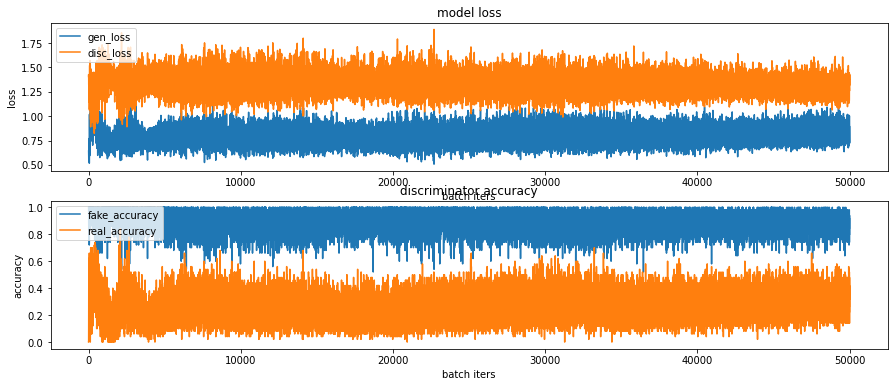

CPU times: user 20min 13s, sys: 3min 44s, total: 23min 57s
Wall time: 22min 40s


In [33]:
%%time
train(train_dataset, EPOCHS, save_every)

#### epoch 수정에 따른 train

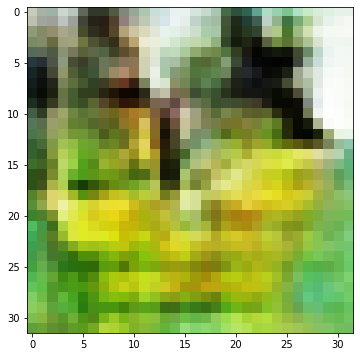

In [34]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

### 학습 과정 시각화하기

In [36]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_defult_model_loss_change_epoch300.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples_default_loss_change_epoch300/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
